In [1]:
import tensorflow as tf

#打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf
from tensorflow.keras import models,layers,losses,metrics,optimizers

#样本数量
n = 400

# 生成测试用数据集
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)  # @表示矩阵乘法,增加正态扰动

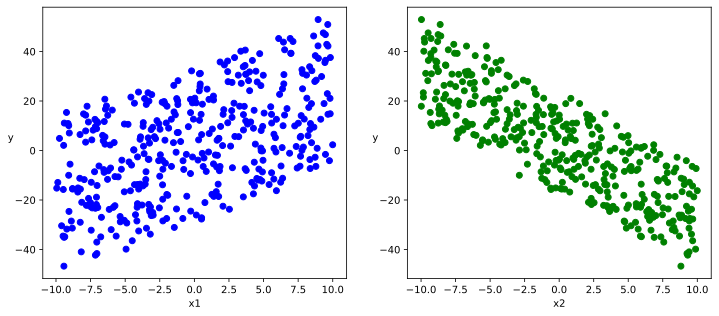

In [3]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

In [4]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(1,input_shape =(2,)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [5]:
### 使用fit方法进行训练

model.compile(optimizer="adam",loss="mse",metrics=["mae"])
model.fit(X,Y,batch_size = 10,epochs = 200)  

tf.print("w = ",model.layers[0].kernel)
tf.print("b = ",model.layers[0].bias)

Epoch 1/200
40/40 [==============================] - 0s 703us/step - loss: 459.9759 - mae: 17.3677
Epoch 2/200
40/40 [==============================] - 0s 679us/step - loss: 447.9707 - mae: 17.1409
Epoch 3/200
40/40 [==============================] - 0s 744us/step - loss: 436.3317 - mae: 16.9143
Epoch 4/200
40/40 [==============================] - 0s 753us/step - loss: 424.8314 - mae: 16.6898
Epoch 5/200
40/40 [==============================] - 0s 709us/step - loss: 413.3513 - mae: 16.4700
Epoch 6/200
40/40 [==============================] - 0s 762us/step - loss: 402.3706 - mae: 16.2471
Epoch 7/200
40/40 [==============================] - 0s 748us/step - loss: 391.4963 - mae: 16.0251
Epoch 8/200
40/40 [==============================] - 0s 878us/step - loss: 380.7701 - mae: 15.8041
Epoch 9/200
40/40 [==============================] - 0s 709us/step - loss: 370.1517 - mae: 15.5894
Epoch 10/200
40/40 [==============================] - 0s 813us/step - loss: 360.0667 - mae: 15.3692
Epoch 11/

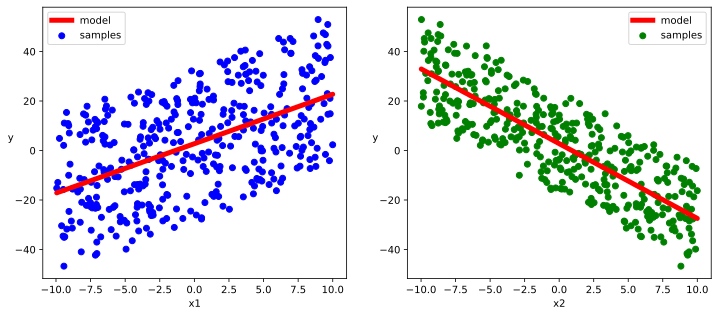

In [6]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.variables

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

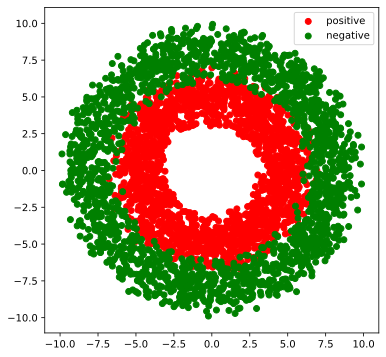

In [7]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,losses,metrics,optimizers
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

#汇总样本
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)

#样本洗牌
data = tf.concat([X,Y],axis = 1)
data = tf.random.shuffle(data)
X = data[:,:2]
Y = data[:,2:]


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);

In [8]:
ds_train = tf.data.Dataset.from_tensor_slices((X[0:n*3//4,:],Y[0:n*3//4,:])) \
     .shuffle(buffer_size = 1000).batch(20) \
     .prefetch(tf.data.experimental.AUTOTUNE) \
     .cache()

ds_valid = tf.data.Dataset.from_tensor_slices((X[n*3//4:,:],Y[n*3//4:,:])) \
     .batch(20) \
     .prefetch(tf.data.experimental.AUTOTUNE) \
     .cache()

In [9]:
tf.keras.backend.clear_session()
class DNNModel(models.Model):
    def __init__(self):
        super(DNNModel, self).__init__()
        
    def build(self,input_shape):
        self.dense1 = layers.Dense(4,activation = "relu",name = "dense1") 
        self.dense2 = layers.Dense(8,activation = "relu",name = "dense2")
        self.dense3 = layers.Dense(1,activation = "sigmoid",name = "dense3")
        super(DNNModel,self).build(input_shape)
 
    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])  
    def call(self,x):
        x = self.dense1(x)
        x = self.dense2(x)
        y = self.dense3(x)
        return y

model = DNNModel()
model.build(input_shape =(None,2))

model.summary()

Model: "dnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               multiple                  12        
_________________________________________________________________
dense2 (Dense)               multiple                  40        
_________________________________________________________________
dense3 (Dense)               multiple                  9         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [10]:
### 自定义训练循环

optimizer = optimizers.Adam(learning_rate=0.01)
loss_func = tf.keras.losses.BinaryCrossentropy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_metric = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

valid_loss = tf.keras.metrics.Mean(name='valid_loss')
valid_metric = tf.keras.metrics.BinaryAccuracy(name='valid_accuracy')



In [11]:
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = loss_func(labels, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss.update_state(loss)
    train_metric.update_state(labels, predictions)

@tf.function
def valid_step(model, features, labels):
    predictions = model(features)
    batch_loss = loss_func(labels, predictions)
    valid_loss.update_state(batch_loss)
    valid_metric.update_state(labels, predictions)
    

def train_model(model,ds_train,ds_valid,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in ds_train:
            train_step(model,features,labels)

        for features, labels in ds_valid:
            valid_step(model,features,labels)

        logs = 'Epoch={},Loss:{},Accuracy:{},Valid Loss:{},Valid Accuracy:{}'
        
        if  epoch%100 ==0:
            printbar()
            tf.print(tf.strings.format(logs,
            (epoch,train_loss.result(),train_metric.result(),valid_loss.result(),valid_metric.result())))
        
        train_loss.reset_states()
        valid_loss.reset_states()
        train_metric.reset_states()
        valid_metric.reset_states()

In [12]:
train_model(model,ds_train,ds_valid,1000)

================================================================================11:25:26
Epoch=100,Loss:0.131499365,Accuracy:0.926666677,Valid Loss:0.136708826,Valid Accuracy:0.93972975
================================================================================11:25:34
Epoch=200,Loss:0.122468702,Accuracy:0.936666667,Valid Loss:0.131732792,Valid Accuracy:0.940540552
================================================================================11:25:41
Epoch=300,Loss:0.115129404,Accuracy:0.94,Valid Loss:0.129693359,Valid Accuracy:0.9408108
================================================================================11:25:48
Epoch=400,Loss:0.110648617,Accuracy:0.946666658,Valid Loss:0.132082015,Valid Accuracy:0.93972975
================================================================================11:25:56
Epoch=500,Loss:0.106788471,Accuracy:0.943333328,Valid Loss:0.133722082,Valid Accuracy:0.93972975
=============================================================================

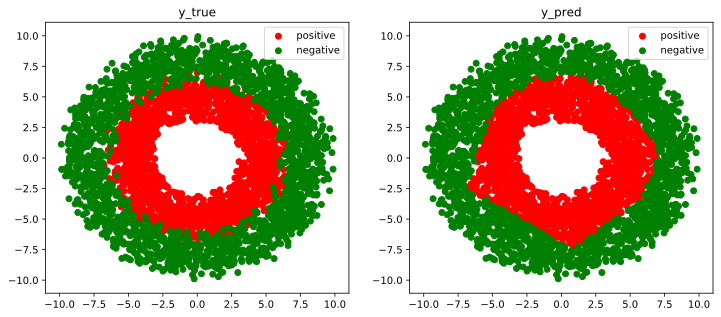

In [13]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
ax1.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0].numpy(),Xp_pred[:,1].numpy(),c = "r")
ax2.scatter(Xn_pred[:,0].numpy(),Xn_pred[:,1].numpy(),c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");